# Análisis espectral: periodograma, regresión con componentes.

In [1]:
## Ejemplo: instalación de astsadata usando pip:
#!pip install astsadata
#Importo astsadata
import warnings
with warnings.catch_warnings(action="ignore"):
    import astsadata as astsa

## Ajusto tamaño de figuras
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

## Componentes estacionales y periodograma

Otra de las componentes que nos gustaría analizar cuando exploramos un ajuste de serie temporal es la presencia de componentes periódicas.

**Ejemplos:**
 1. La mezcla de $\sin$ y $\cos$ del ejercicio del cuaderno pasado.
 2. El SOI visto más arriba (y el recruitement si le creemos al libro).

**Idea:** ¿Como sistematizar el encontrar componentes periódicas?

### Ejemplo: señal artificial (mezcla de $\sin$ y $\cos$)

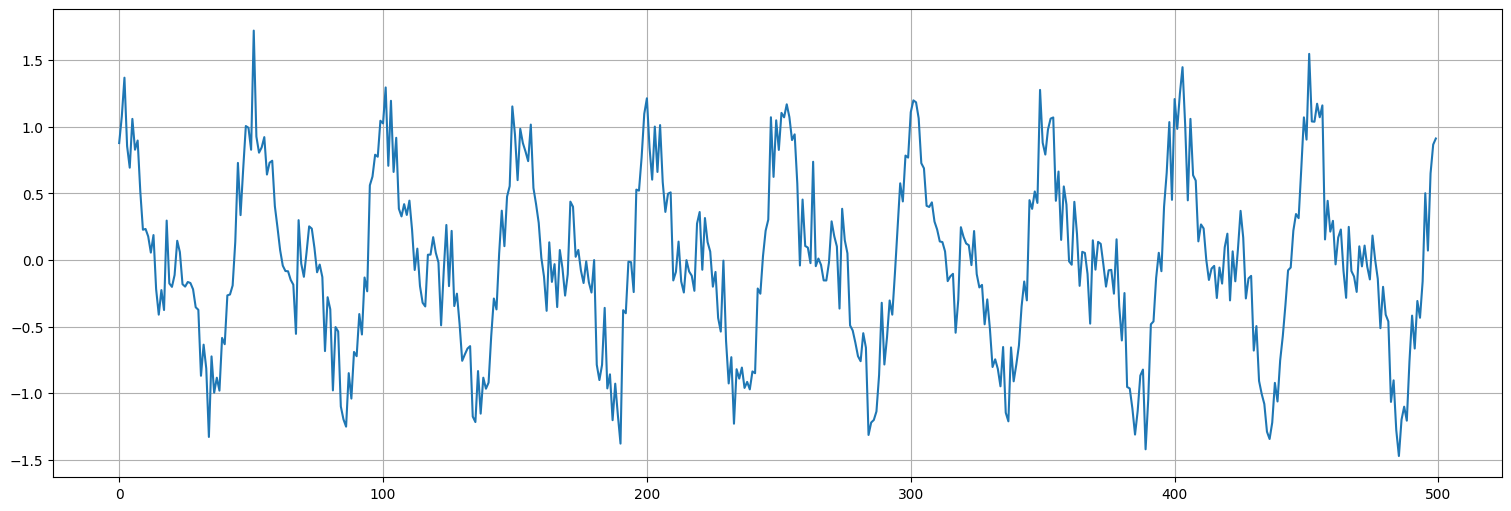

In [2]:
import numpy as np

t=np.arange(0,500)
f=1/50 #frecuencia fundamental
signal = 0.5*np.cos(2*np.pi*f*t) + 0.5*np.sin(2*np.pi*f*t) + 0.5*np.cos(2*np.pi*2*f*t)
noise = np.random.normal(size=t.size,loc=0,scale=0.2)

x = signal + noise

plt.plot(t,x);

### Idea 1: recurrir a la ACF

Calcular la autocorrelación de la señal y ver si aparecen picos. Similar a lo hecho para el SOI arriba.

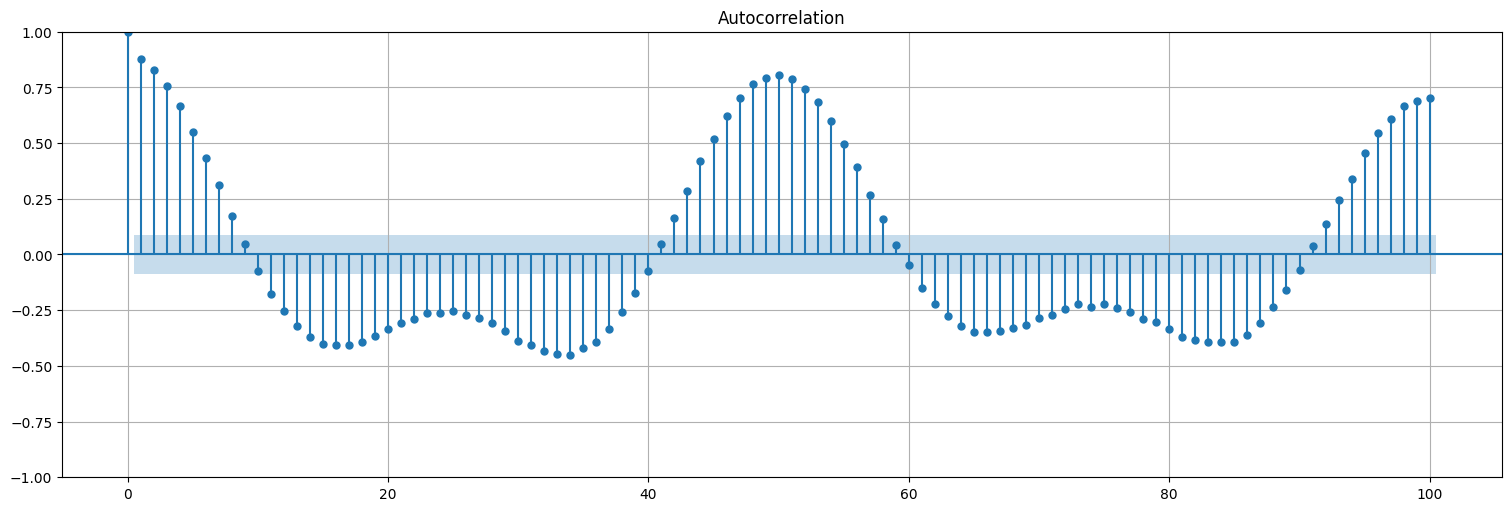

In [3]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(x, lags=100, bartlett_confint=False);

### Idea 2: correlacionar con una señal de frecuencia conocida

La idea es tomar señales de la forma:

$$ c^f_t = \cos(2\pi f t) \quad s^f_t = \sin(2 \pi f t).$$

Si el valor $P^f = \rho(x,c^f_t) ^2 + \rho(x,s^f_t)^2$ es alto, esa frecuencia está presente en la señal. Aqui $\rho$ indica correlación cruzada entre la señal y el $\cos/\sin$.

**Ejemplo:**

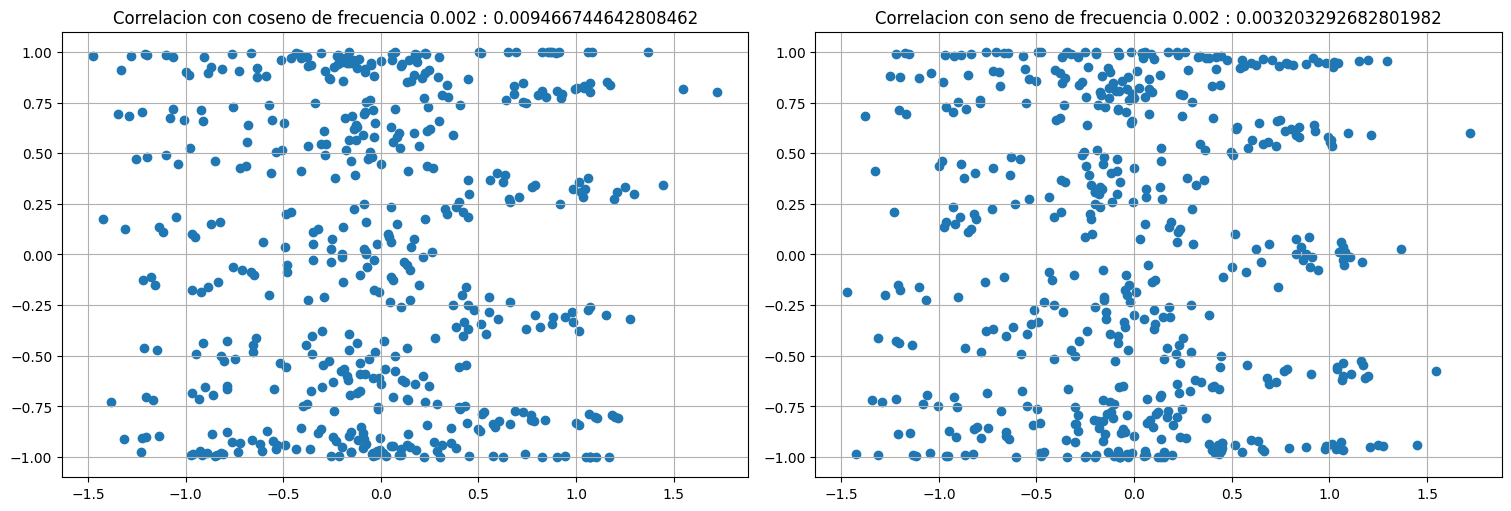

In [4]:
#Probar con diferentes frecuencias:
f=1/500         # frecuencia a correlacionar. Si no está presente, no hay correlación.
#f=1/50          # frecuencia a correlacionar. Si está presente, hay correlación.
#f=1/25          # frecuencia a correlacionar. Si está presente, no hay correlación.

c1 = np.cos(2*np.pi*f*t)
s1 = np.sin(2*np.pi*f*t)

plt.subplot(1, 2,1)
plt.scatter(x,c1)
plt.title(f"Correlacion con coseno de frecuencia {f} : {np.corrcoef(x,c1)[0,1]}");
plt.subplot(1,2,2)
plt.scatter(x,s1)
plt.title(f"Correlacion con seno de frecuencia {f} : {np.corrcoef(x,s1)[0,1]}");

### Periodograma (transformada discreta de Fourier)

El *periodograma* es una forma sistemática de recorrer las correlaciones anteriores y calcular cuáles son significativas.

> **Definición:** Transformada Discreta de Fourier
>
> Dada una serie temporal $x_t$ de largo $n$ se define su DFT (Discrete Fourier Transform) como el vector complejo:
>  
> $$DFT_x(j/n) = \sum_{t} x_t \cos\left(2\pi \frac{j}{n} t\right) - i  \sum_{t} x_t \sin\left(2\pi \frac{j}{n} t\right) = \rho(x,c^{j/n}_t) - i \rho(x,s^{j/n}_t)$$

Es decir, $DFT_x$ guarda las covarianzas (correlaciones no escaladas) con cosenos y senos de las frecuencias de la forma $j/n$ siendo $n$ la cantidad de datos.

Observar que el módulo $|DFT_x(j/n)|^2 = \rho(x,c^{j/n}_t) ^2 + \rho(x,s^{j/n}_t)^2$ nos da idea de la "fuerza" de esta frecuencia.

### El rol de $j$

La idea de la DFT es calcular sistemáticamente las correlaciones contra las frecuencias de la forma $j/n$, siendo $n$ el largo de los datos.

* $j=0$ correspondería a $\cos(0) \equiv 1$ y $\sin(0)\equiv 0$, que es lo mismo que sumar los datos. Es por ello que conviene *centrar* los datos antes de trabajar (eliminar la media).

* $0<j<n/2$ corresponde a las frecuencias observables. La interpretación de $j$ aquí es la cantidad de *ciclos* en la muestra que se presentan a dicha frecuencia.
  
  **Ejemplo:** En una serie de frecuencia anual ($12$ muestras por año) y $120$ observaciones ($10$ años), una componente anual debería aparecer para $j=10$ ($10$ ciclos en la muestra) o bien $j/n=10/120=1/12$.

* $j=n/2$ es la máxima frecuencia observable. ¿Por qué? Porque para poder "observar" adecuadamente una frecuencia necesitamos al menos dos muestras por ciclo. Si tenemos $n$ datos, dicha frecuencia máxima corresponde a $j=n/2$ ciclos en la muestra.

### FFT: Fast Fourier Transform

Numéricamente se calcula la $DFT$ usando el algoritmo FFT: Fast Fourier Transform, que reusa varios de los cálculos de correlación para una implementación más eficiente.

En `python` usando `numpy`:
  * La FFT (DFT) se obtiene mediante `numpy.fft(x)`. 
  * Se calcula $I(j/n) = |DFT_x (j/n)|^2$, el módulo cuadrado del complejo resultante.
  * Luego se obtiene el Periodograma $P$ escalado definido como:
      $$P(j/n) = \frac{4}{n^2} I(j/n) , \quad j=0,\ldots,n/2.$$
      El coeficiente $4/n^2$ lleva la escala a los coeficientes de regresión contra seno y coseno.
  * Si se desea graficar el periodograma $P$ en las frecuencias originales de la serie, se debe usar en las abscisas el vector de frecuencias:
      
      `f = [0, 1/n, 2/n, ..., (n/2-1)/n] * freq`

    siendo `freq` la frecuencia de la serie (frecuencia de muestreo).

Utilizando este método definimos la siguiente función que calcula el periodograma escalado para una serie:

In [5]:
def periodogram(x,sampling_frequency=1):

    """Función que calcula el periodograma y grafica.
    
    Parameters
    ----------
        x : array_like, data.
        sampling_frequency: frecuencia de muestreo de la serie, para graficar.
    """

    n = x.size
    P = 4/n**2 * np.abs(np.fft.fft(x))**2
    P = P[0:round(n/2)]
    f = np.arange(0,round(n/2))/n * sampling_frequency
    plt.plot(f,P);
    plt.xlabel("Frequency")
    plt.ylabel("Power")


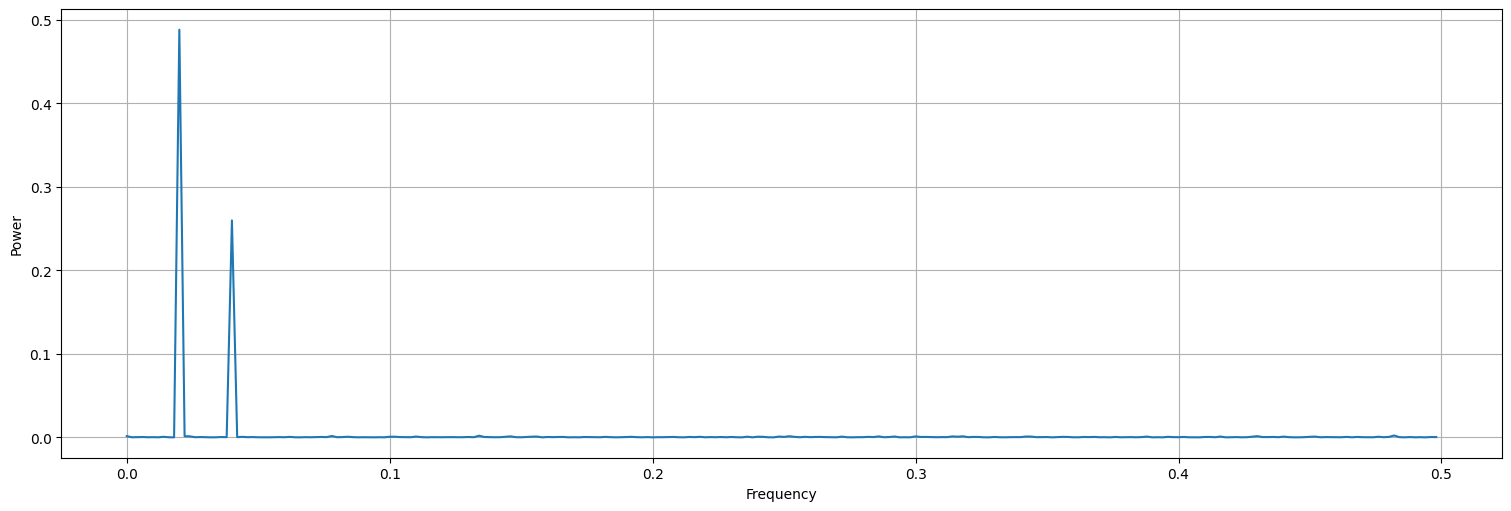

In [6]:
periodogram(x)

#### Observación

Notar que las alturas del periodograma guardan relación con los coeficientes de seno y coseno involucrados en la señal.

### Análisis espectral

Con la misma idea podemos hacer una función que indique cuáles fueron las frecuencias más importantes:

In [7]:
import pandas as pd

def spectrum(x,sampling_frequency=1, nfreq=10):

    """Función que calcula las componentes más relevantes del periodograma.
    
    Parameters
    ----------
        x : array_like, data.
        sampling_frequency: frecuencia de muestreo de la serie, para graficar.
    """

    n = x.size
    nfreq = np.minimum(nfreq,round(n/2)) #corto nfreq si la serie es muy corta!
    P = 4/n**2 * np.abs(np.fft.fft(x))**2
    P = P[0:round(n/2)]
    f = np.arange(0,round(n/2))/n * sampling_frequency
    index = np.argsort(P)[::-1] #ordeno P decreciente
    return pd.DataFrame({"Frecuencia" : f[index[0:nfreq]],"Potencia" : P[index[0:nfreq]]})

In [8]:
df = spectrum(x)
print(df)

   Frecuencia  Potencia
0       0.020  0.488231
1       0.040  0.259822
2       0.482  0.002201
3       0.134  0.001944
4       0.078  0.001613
5       0.000  0.001450
6       0.430  0.001411
7       0.022  0.001359
8       0.252  0.001330
9       0.318  0.001240


### Regresión lineal para ajustar

Luego de identificadas las frecuencias más relevantes, el último paso es simplemente ajustar una regresión lineal incluyendo todos los términos que sean necesarios.

#### Ejemplo:

En el caso anterior identificamos las frecuencias $0.02$ y $0.04$ que estaban en la serie original. Hacemos entonces una regresión de la forma:

$$x_t = \beta_0 + \beta_1 \cos(2\pi (0.02) t) + \beta_2 \sin(2\pi (0.02) t) + \beta_3 \cos(2\pi (0.04) t) + \beta_4 \cos(2\pi (0.04) t) + w_t$$

y luego analizamos los residuos. Si sabemos que la serie está centrada podemos prescindir de $\beta_0$ (el intercept).

In [9]:
from statsmodels.formula.api import ols

t = np.arange(0,500)
data = pd.Series({"x":x,"time":t})
fit = ols(formula='x~np.cos(2*np.pi*0.02*time) + np.sin(2*np.pi*0.02*time) + np.cos(2*np.pi*0.04*time) + np.sin(2*np.pi*0.04*time)', data=data).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      x   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     1088.
Date:                Sun, 10 Nov 2024   Prob (F-statistic):          1.19e-243
Time:                        20:45:22   Log-Likelihood:                 79.933
No. Observations:                 500   AIC:                            -149.9
Df Residuals:                     495   BIC:                            -128.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.0190      0.009     -2.054      0.040      -0.037      -0.001
np.cos(2 * np.pi * 0.02 * time)     0.4942      0.013     37.700      0.000       0.468       0.520
np.sin(2 * np.pi * 0.02 * time)     0.4940      0.013     37.684      0.000       0.468       0.520
np.cos(2 * np.pi * 0.04 * time)     0.5095      0.013     38.871      0.000       0.484       0.535
np.sin(2 * np.pi * 0.04 * time)     0.0139      0.013      1.064      0.288      -0.012       0.040
==============================================================================
Omnibus:                        6.053   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                7.136
Skew:                           0.141   Prob(JB):                       0.0282
Kurtosis:                       3.513   Cond. No.                         1.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Luego descartamos los no significativos (ej: el intercept y el seno de frecuencia alta en este caso).

In [10]:
fit = ols(formula='x~0+np.cos(2*np.pi*0.02*time) + np.sin(2*np.pi*0.02*time) + np.cos(2*np.pi*0.04*time)', data=data).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      x   R-squared (uncentered):                   0.897
Model:                            OLS   Adj. R-squared (uncentered):              0.896
Method:                 Least Squares   F-statistic:                              1441.
Date:                Sun, 10 Nov 2024   Prob (F-statistic):                   1.07e-244
Time:                        20:45:22   Log-Likelihood:                          77.244
No. Observations:                 500   AIC:                                     -148.5
Df Residuals:                     497   BIC:                                     -135.8
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
np.cos(2 * np.pi * 0.02 * time)     0.4942      0.013     37.573      0.000       0.468       0.520
np.sin(2 * np.pi * 0.02 * time)     0.4940      0.013     37.558      0.000       0.468       0.520
np.cos(2 * np.pi * 0.04 * time)     0.5095      0.013     38.741      0.000       0.484       0.535
==============================================================================
Omnibus:                        6.590   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                7.890
Skew:                           0.150   Prob(JB):                       0.0194
Kurtosis:                       3.537   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Ajuste:

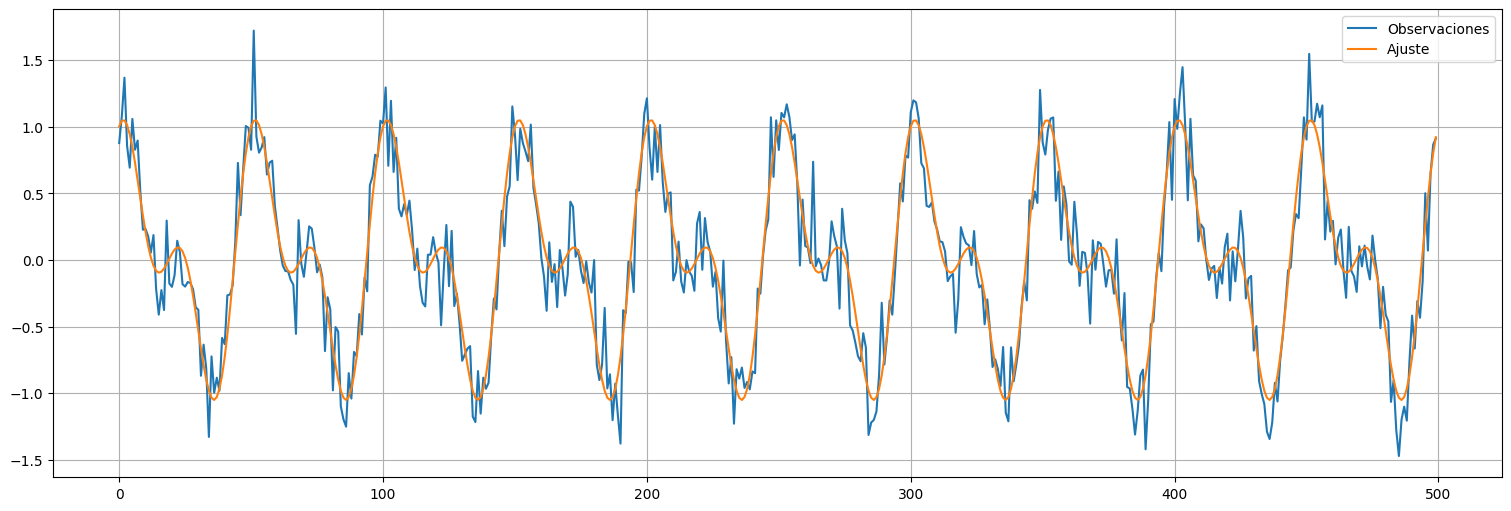

In [11]:
plt.plot(t,x, label="Observaciones");
plt.plot(t,fit.fittedvalues, label="Ajuste");
plt.legend();

#### Residuos:

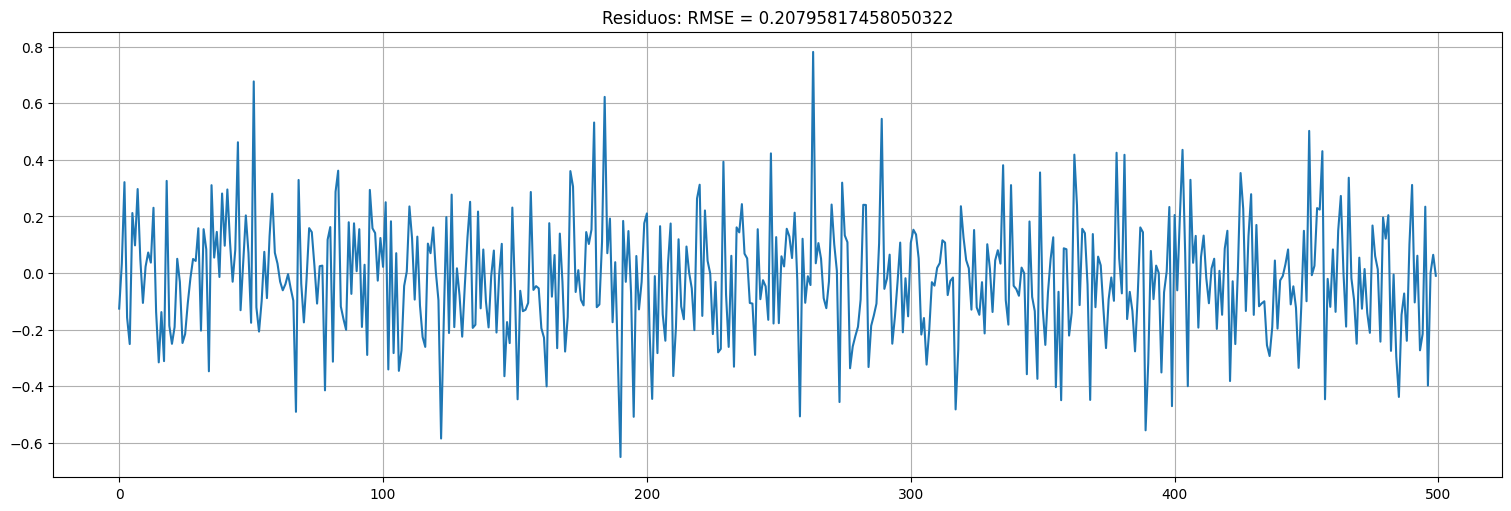

In [12]:
plt.plot(t,fit.resid);
plt.title(f"Residuos: RMSE = {np.sqrt(fit.mse_resid)}");

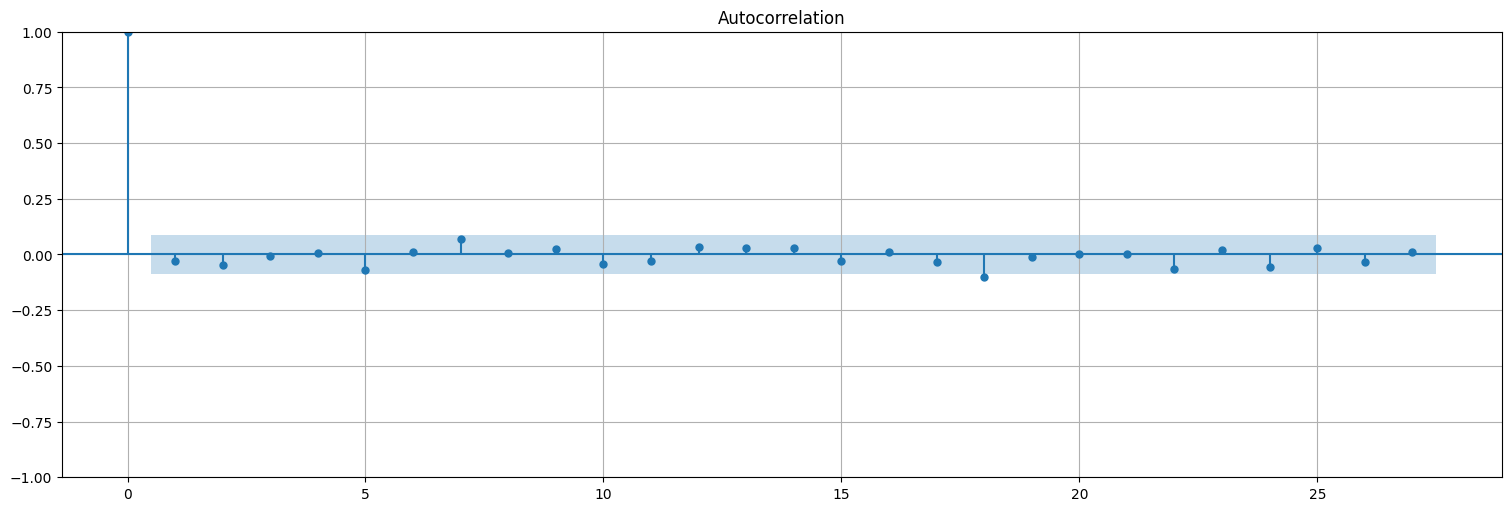

In [13]:
plot_acf(fit.resid,bartlett_confint=False);

## Aplicación:

Apliquemos la idea del periodograma a las series SOI y Recruitement de la biblioteca astsa

In [14]:
soi = astsa.soi
rec = astsa.rec
soi.head() #notar que las medidas son mensuales

,value
index,
1950-01,0.377
1950-02,0.246
1950-03,0.311
1950-04,0.104
1950-05,-0.016


### Importante: 

Como ya mencionamos, antes de calcular el periodograma, debemos centrar la serie.

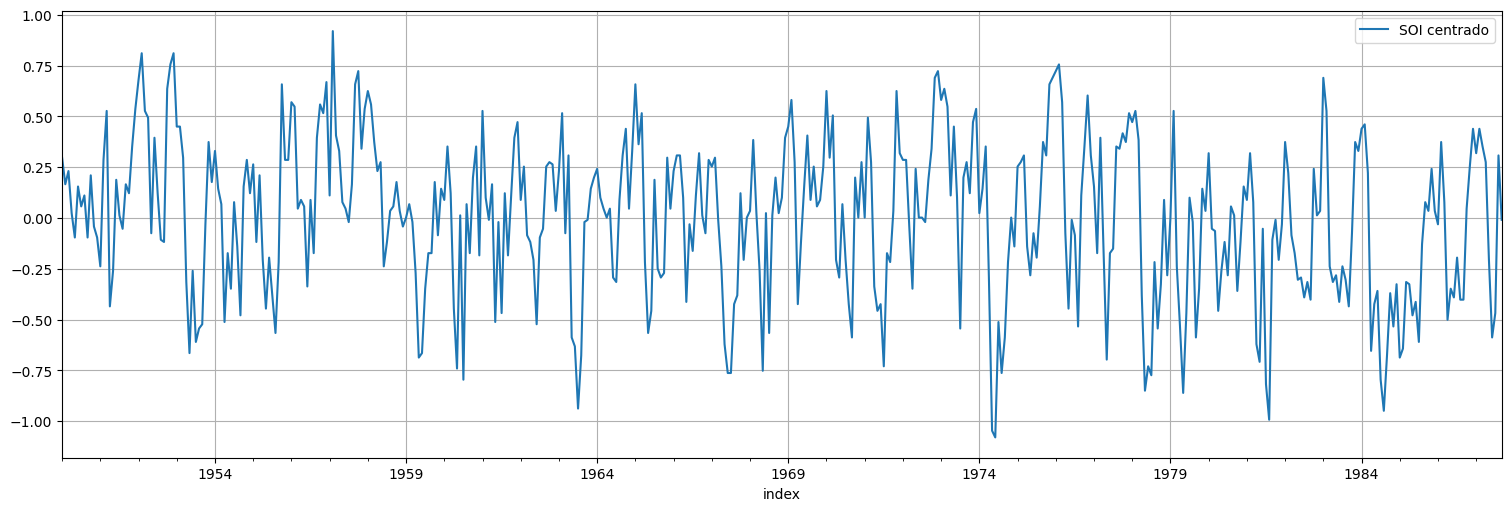

In [15]:
s = soi-np.mean(soi)
s.plot().legend(["SOI centrado"]);

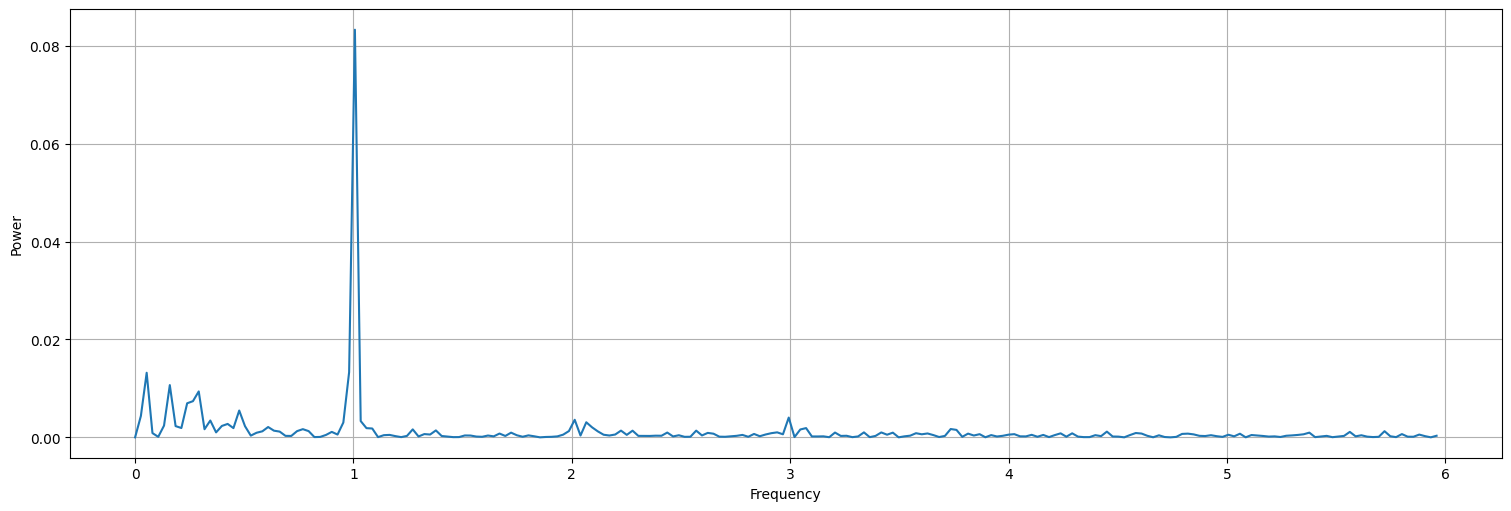

In [16]:
periodogram(s.value, sampling_frequency=12)

In [17]:
spectrum(s.value, sampling_frequency=12)

,Frecuencia,Potencia
0,1.006623,0.083315
1,0.980132,0.013316
2,0.052980,0.013200
3,0.158940,0.010678
4,0.291391,0.009385
5,0.264901,0.007391
6,0.238411,0.006961
7,0.476821,0.005480
8,0.026490,0.004373
9,2.993377,0.004042


Luego hacemos la regresión, volviendo a incorporar el intercept con los datos sin centrar. El intercept se hace cargo de la media.

In [18]:
time = pd.Series(np.arange(0,soi.size)/12,index=soi.index) #creo una columna de tiempos
data = pd.concat([time,soi], axis=1)
data.columns = ["time","soi"]

fit = ols(formula="soi~np.cos(2*np.pi*time) + np.sin(2*np.pi*time)",data=data).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    soi   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     123.8
Date:                Sun, 10 Nov 2024   Prob (F-statistic):           1.47e-43
Time:                        20:45:22   Log-Likelihood:                -107.94
No. Observations:                 453   AIC:                             221.9
Df Residuals:                     450   BIC:                             234.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0815      0.014      5.627      0.000       0.053       0.110
np.cos(2 * np.pi * time)     0.3082      0.020     15.073      0.000       0.268       0.348
np.sin(2 * np.pi * time)    -0.0937      0.020     -4.571      0.000      -0.134      -0.053
==============================================================================
Omnibus:                        5.111   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                4.859
Skew:                          -0.206   Prob(JB):                       0.0881
Kurtosis:                       2.705   Cond. No.                         1.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

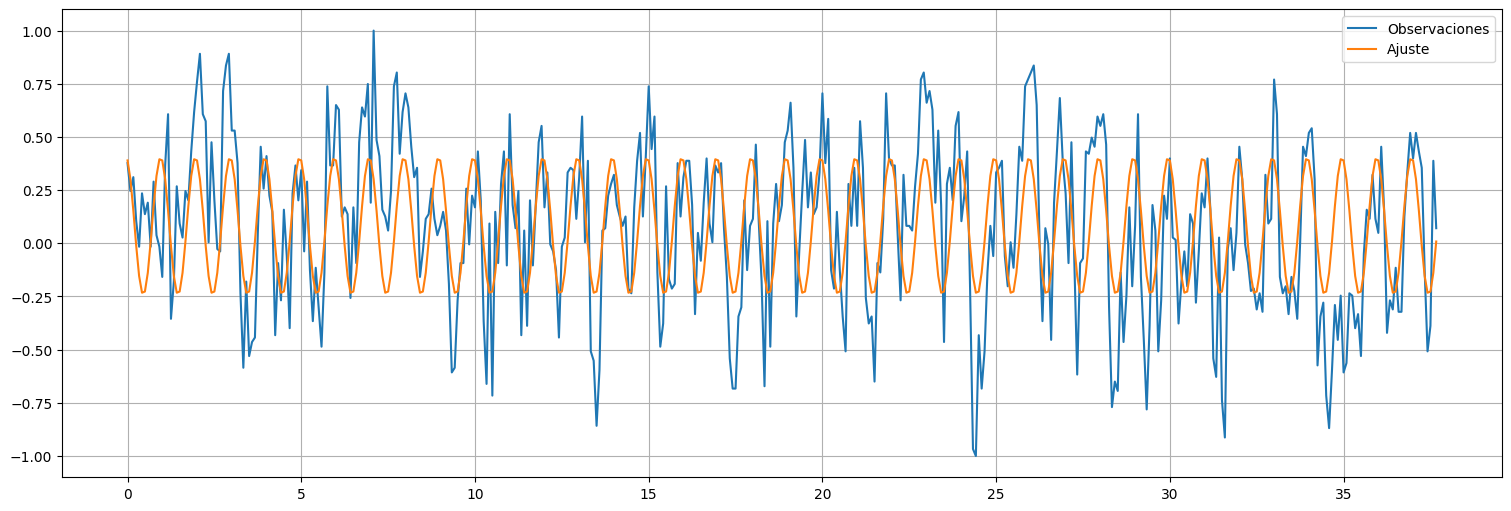

In [19]:
plt.plot(time,soi, label="Observaciones");
plt.plot(time,fit.fittedvalues, label="Ajuste");
plt.legend();

Agregamos ahora componentes de baja frecuencia del espectro:

In [20]:
f0 = 1.0
f1 = 0.052980
f2 = 0.158940
fit = ols(formula="soi~np.cos(2*np.pi*f0*time) + np.sin(2*np.pi*f0*time) + np.cos(2*np.pi*f1*time) + np.sin(2*np.pi*f1*time) + np.cos(2*np.pi*f2*time) + np.sin(2*np.pi*f2*time) ",data=data).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    soi   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     57.83
Date:                Sun, 10 Nov 2024   Prob (F-statistic):           8.95e-53
Time:                        20:45:23   Log-Likelihood:                -76.873
No. Observations:                 453   AIC:                             167.7
Df Residuals:                     446   BIC:                             196.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0815      0.014      6.000      0.000       0.055       0.108
np.cos(2 * np.pi * f0 * time)     0.3087      0.019     16.093      0.000       0.271       0.346
np.sin(2 * np.pi * f0 * time)    -0.0939      0.019     -4.885      0.000      -0.132      -0.056
np.cos(2 * np.pi * f1 * time)     0.0057      0.019      0.295      0.768      -0.032       0.043
np.sin(2 * np.pi * f1 * time)     0.1150      0.019      5.987      0.000       0.077       0.153
np.cos(2 * np.pi * f2 * time)     0.0338      0.019      1.759      0.079      -0.004       0.072
np.sin(2 * np.pi * f2 * time)     0.0989      0.019      5.152      0.000       0.061       0.137
==============================================================================
Omnibus:                        7.674   Durbin-Watson:                   1.236
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.513
Skew:                          -0.280   Prob(JB):                       0.0234
Kurtosis:                       2.710   Cond. No.                         1.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

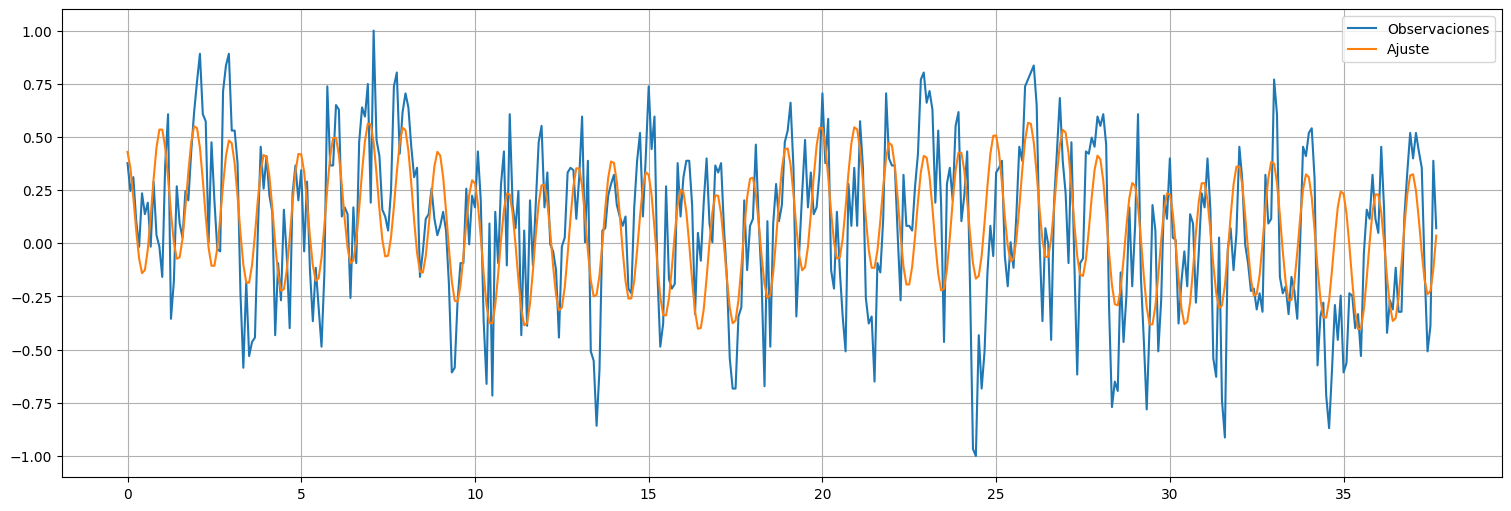

In [21]:
plt.plot(time,soi, label="Observaciones");
plt.plot(time,fit.fittedvalues, label="Ajuste");
plt.legend();

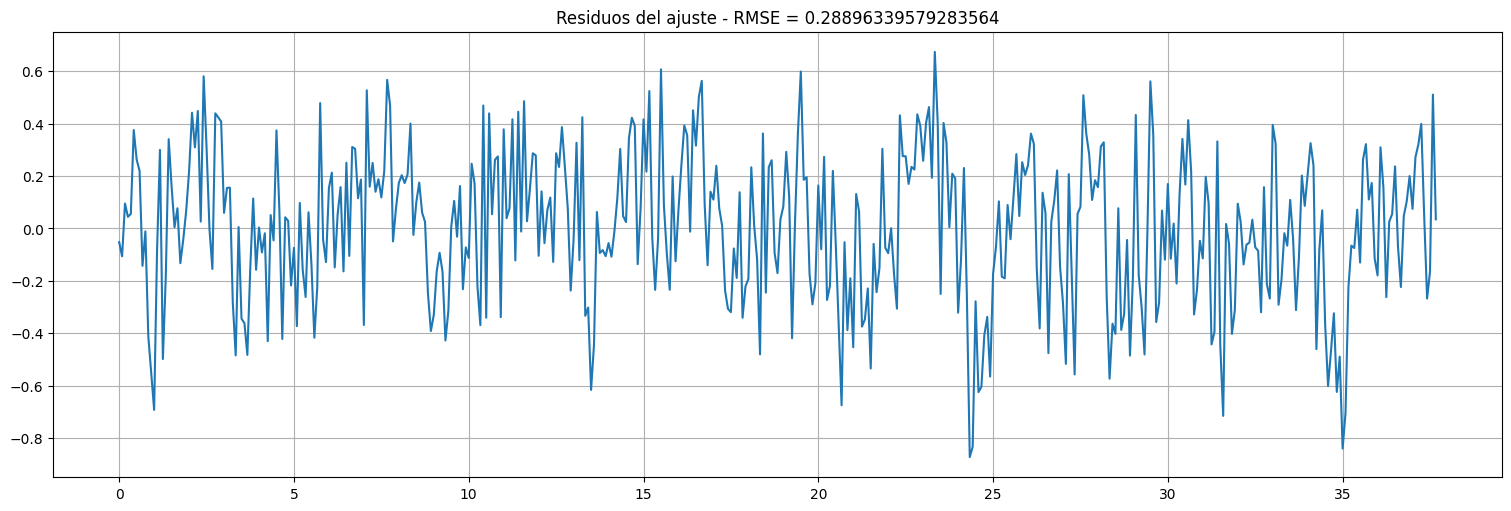

In [22]:
plt.plot(time,fit.resid); 
plt.title(f"Residuos del ajuste - RMSE = {np.sqrt(fit.mse_resid)}");

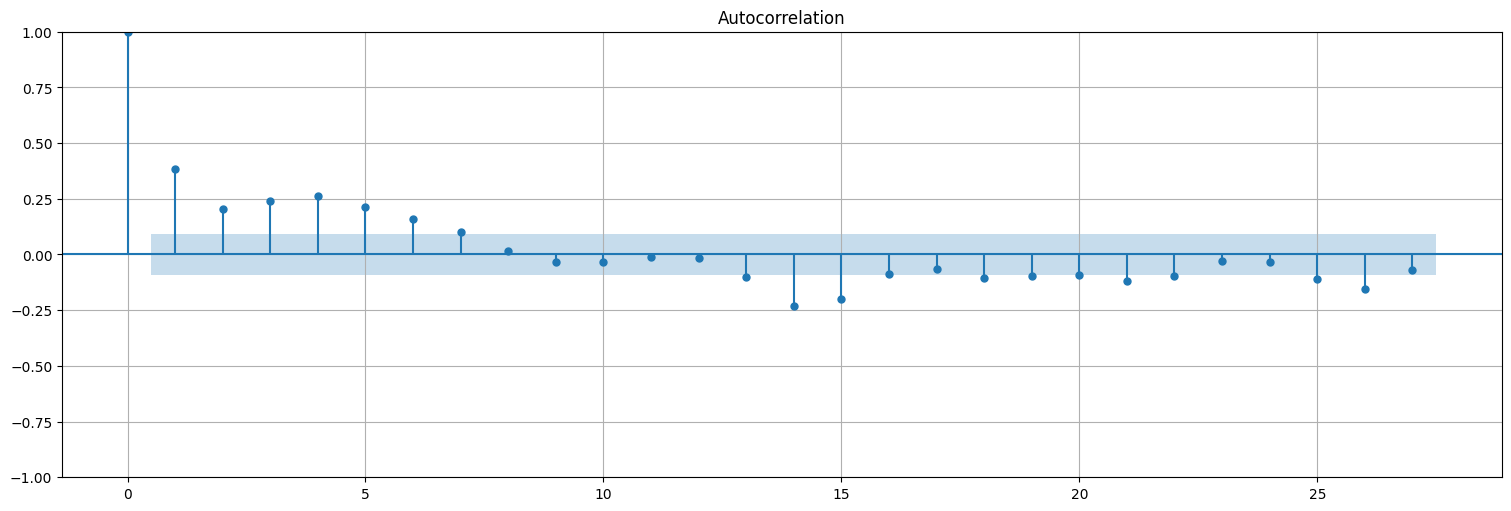

In [23]:
plot_acf(fit.resid, bartlett_confint=False);

Podemos hacer lo mismo para el Recruitment...

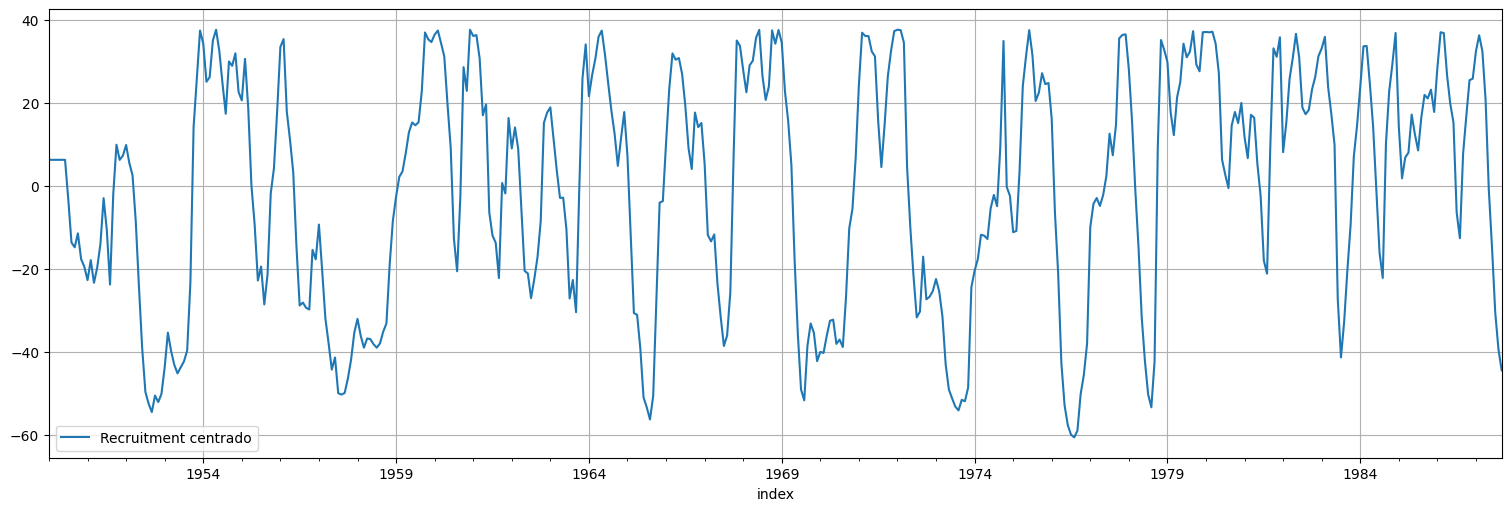

In [24]:
r = rec - np.mean(rec)
r.plot().legend(["Recruitment centrado"]);

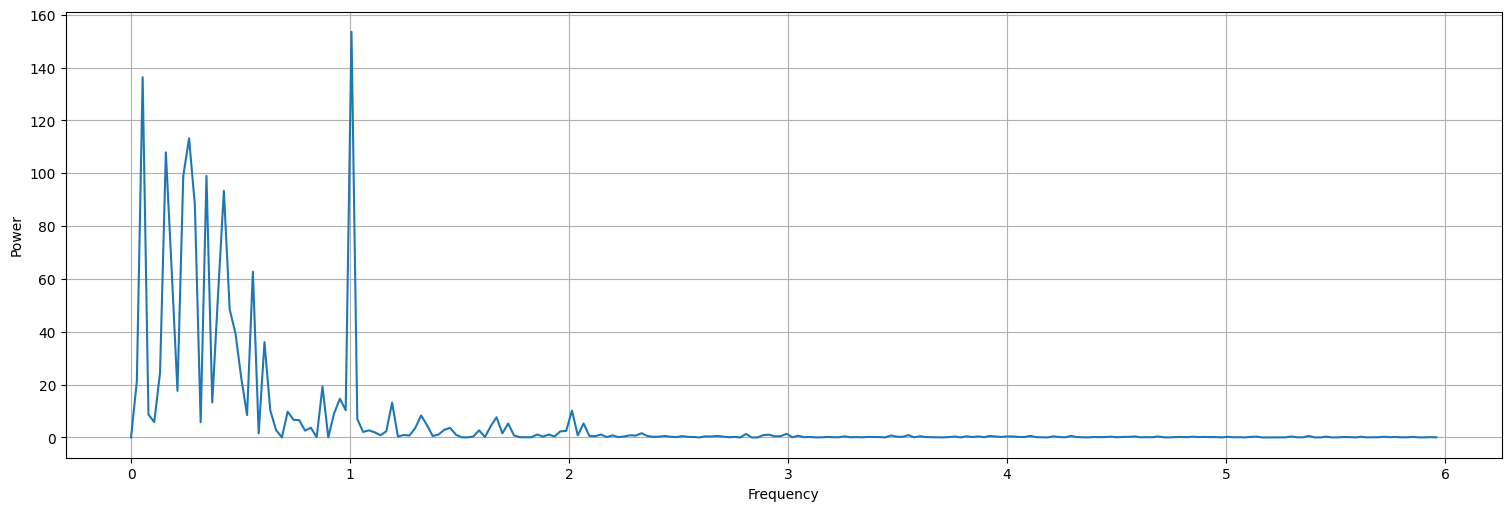

In [25]:
periodogram(r.value, sampling_frequency=12)

### Observaciones

* La frecuencia anual aparece en el periodograma (el pico es en  $j=38$, cuando la muestra tiene casi $38$ años de datos precisamente). No era clara en la correlación en el caso de `rec` pero aquí sí se observa claramente.
* Aparecen frecuencias *más lentas*, tanto en `soi` como en `rec`. En el caso de `rec` aparecen varios picos en frecuencias casi contiguas, de períodos mayores a un año.
* No siempre los picos son todos relevantes. A veces es necesario *suavizar* el periodograma para extraer las frecuencias relevantes.
* Por ejemplo, aparecen picos cercanos a $f=0.25$ que corresponden con el ciclo el fenómeno del Niño (cada 4 años).

## Un ejemplo completo: la serie Air Passengers

Esta es una serie clásica que también analizaremos con otras técnicas más adelante. Por ahora veamos como podemos combinar todo lo visto anteriormente para hacer un ajuste.

Se tiene $x_t=$ miles de pasajeros mensuales internacionales en el transporte aéreo.

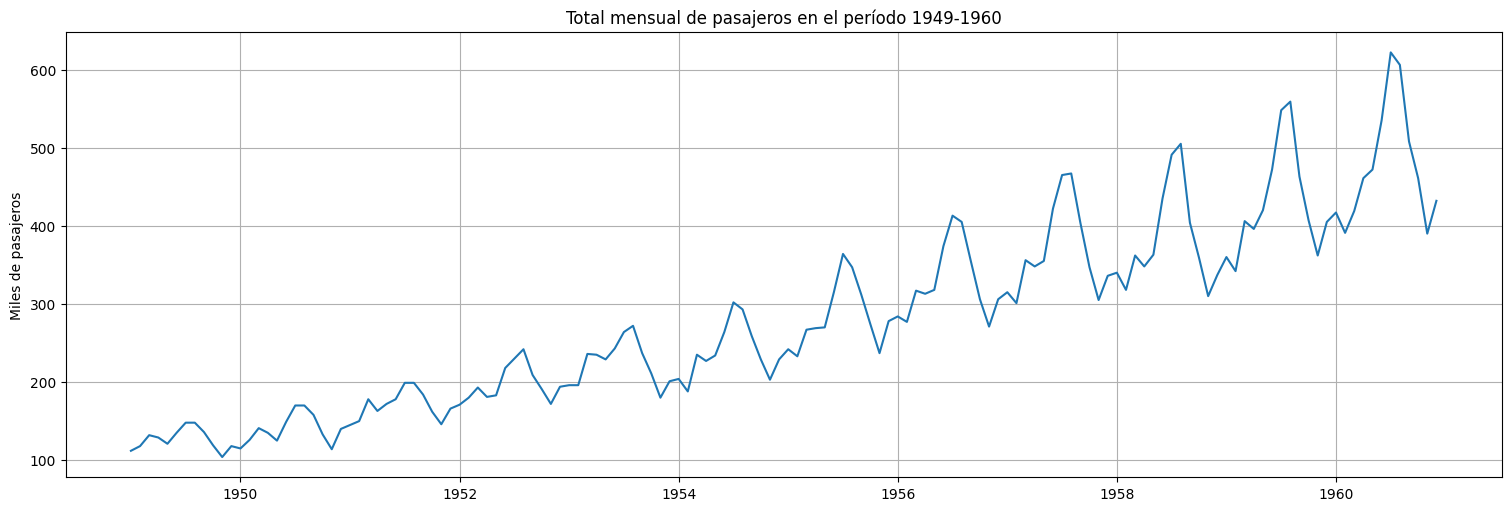

In [26]:
df = pd.read_csv('../data/international-airline-passengers.csv', names = ['year','passengers'], header=0)
air = pd.Series(df["passengers"].values, index=np.arange(1949,1961,1/12))
time = pd.Series(np.arange(1949,1961,1/12), index=np.arange(1949,1961,1/12))
air.plot();
plt.title("Total mensual de pasajeros en el período 1949-1960")
plt.ylabel("Miles de pasajeros");

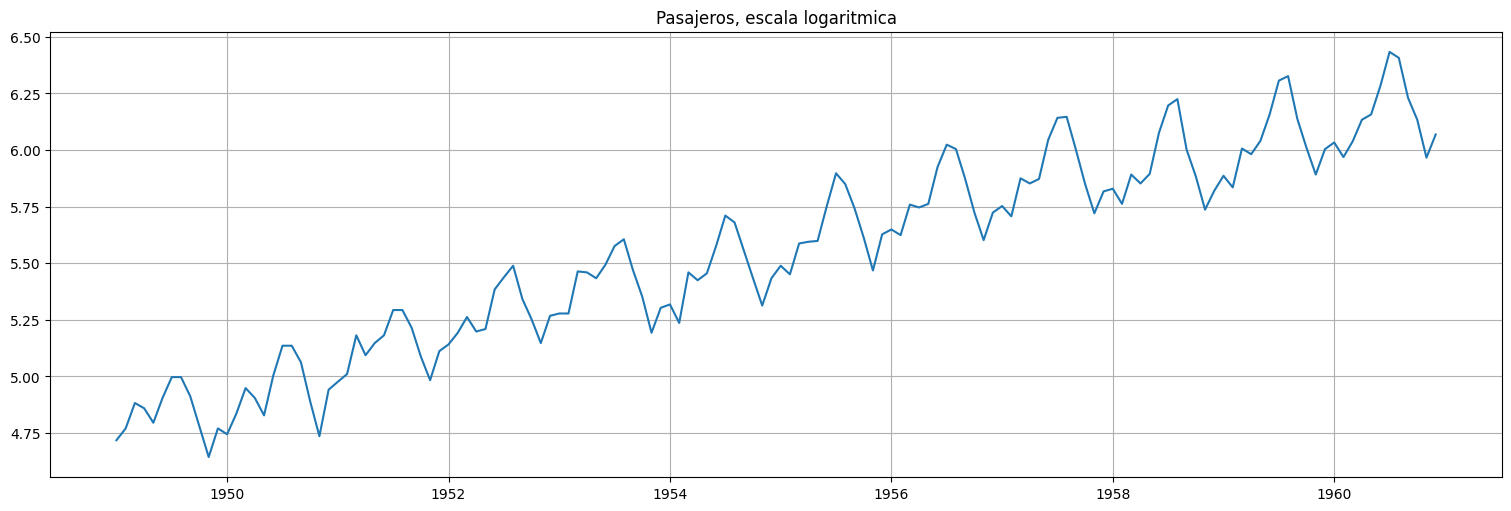

In [27]:
logair = np.log(air);
logair.plot();
plt.title("Pasajeros, escala logaritmica");

In [28]:
data = pd.concat([air,time], axis=1)
fit = ols(formula="logair~time", data=data).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logair   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     1300.
Date:                Sun, 10 Nov 2024   Prob (F-statistic):           2.41e-73
Time:                        20:45:24   Log-Likelihood:                 80.794
No. Observations:                 144   AIC:                            -157.6
Df Residuals:                     142   BIC:                            -151.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -230.1878      6.539    -35.203      0.000    -243.114    -217.262
time           0.1206      0.003     36.050      0.000       0.114       0.127
==============================================================================
Omnibus:                        3.750   Durbin-Watson:                   0.587
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                2.722
Skew:                           0.184   Prob(JB):                        0.256
Kurtosis:                       2.436   Cond. No.                     1.10e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

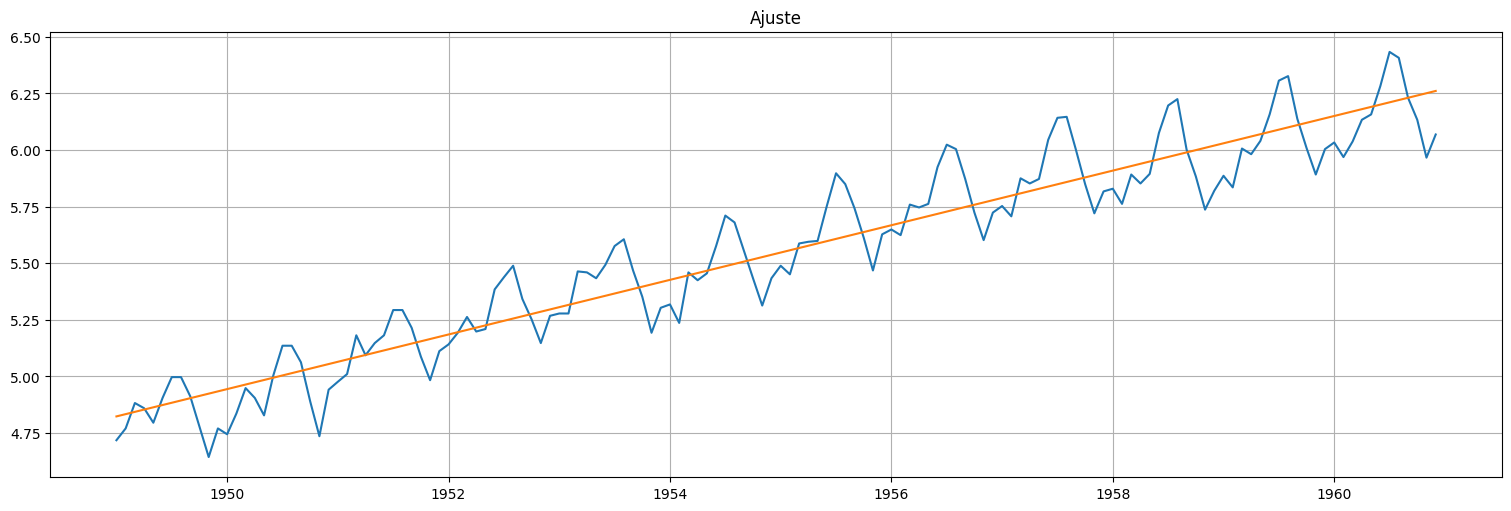

In [29]:
logair.plot()
fit.fittedvalues.plot();
plt.title("Ajuste");

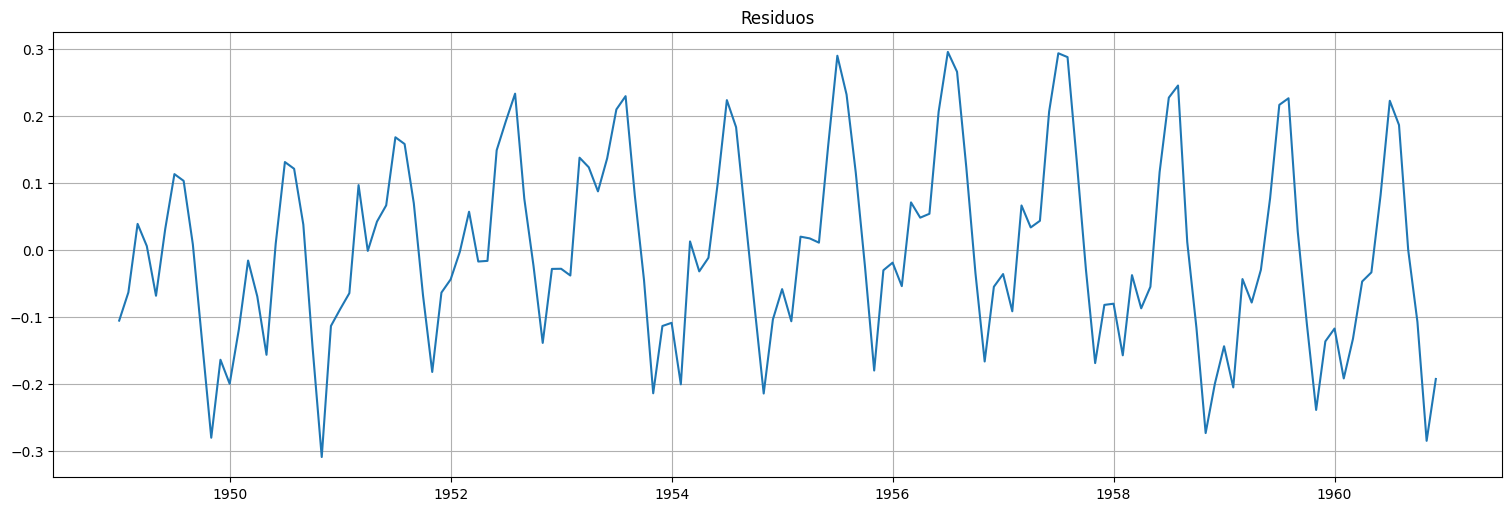

In [30]:
fit.resid.plot()
plt.title("Residuos");

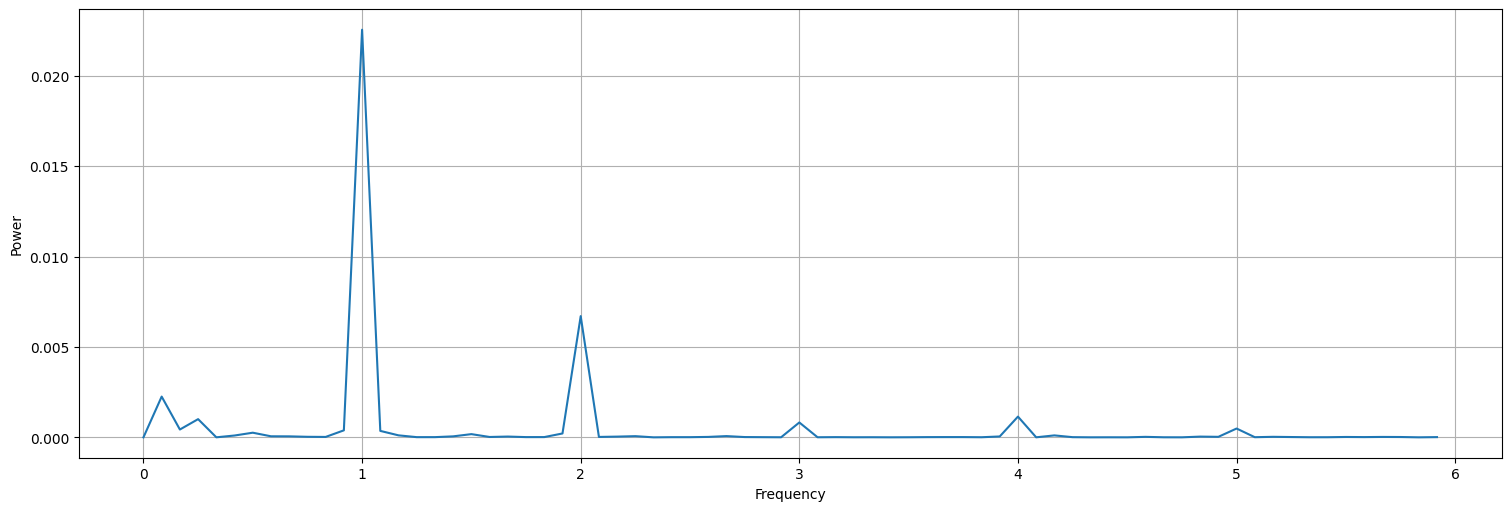

In [31]:
periodogram(fit.resid.values, sampling_frequency=12)

In [32]:
fit = ols(formula="logair~time+np.cos(2*np.pi*time)+np.sin(2*np.pi*time)+np.cos(2*np.pi*2*time)+np.sin(2*np.pi*2*time)", data=air).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logair   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1177.
Date:                Sun, 10 Nov 2024   Prob (F-statistic):          3.03e-111
Time:                        20:45:24   Log-Likelihood:                 185.79
No. Observations:                 144   AIC:                            -359.6
Df Residuals:                     138   BIC:                            -341.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     -230.9817      3.208    -71.998      0.000    -237.325    -224.638
time                             0.1210      0.002     73.725      0.000       0.118       0.124
np.cos(2 * np.pi * time)        -0.1475      0.008    -18.392      0.000      -0.163      -0.132
np.sin(2 * np.pi * time)         0.0282      0.008      3.511      0.001       0.012       0.044
np.cos(2 * np.pi * 2 * time)     0.0567      0.008      7.077      0.000       0.041       0.073
np.sin(2 * np.pi * 2 * time)     0.0591      0.008      7.371      0.000       0.043       0.075
==============================================================================
Omnibus:                        0.996   Durbin-Watson:                   1.099
Prob(Omnibus):                  0.608   Jarque-Bera (JB):                0.908
Skew:                          -0.193   Prob(JB):                        0.635
Kurtosis:                       2.959   Cond. No.                     1.11e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

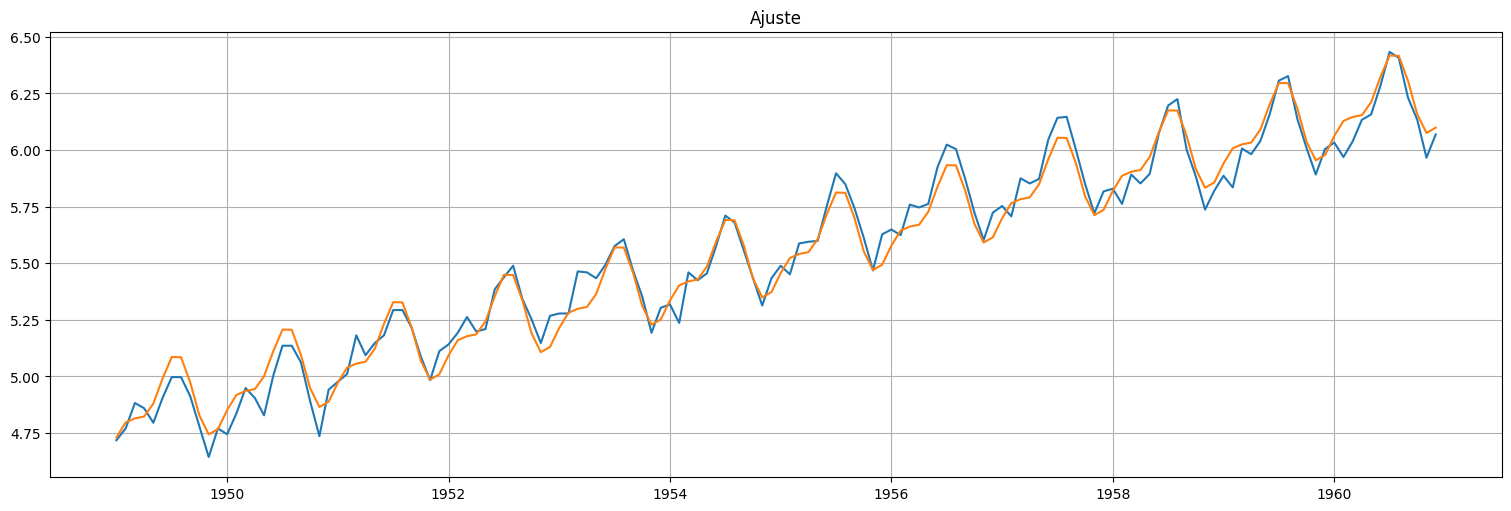

In [33]:
logair.plot()
fit.fittedvalues.plot()
plt.title("Ajuste");

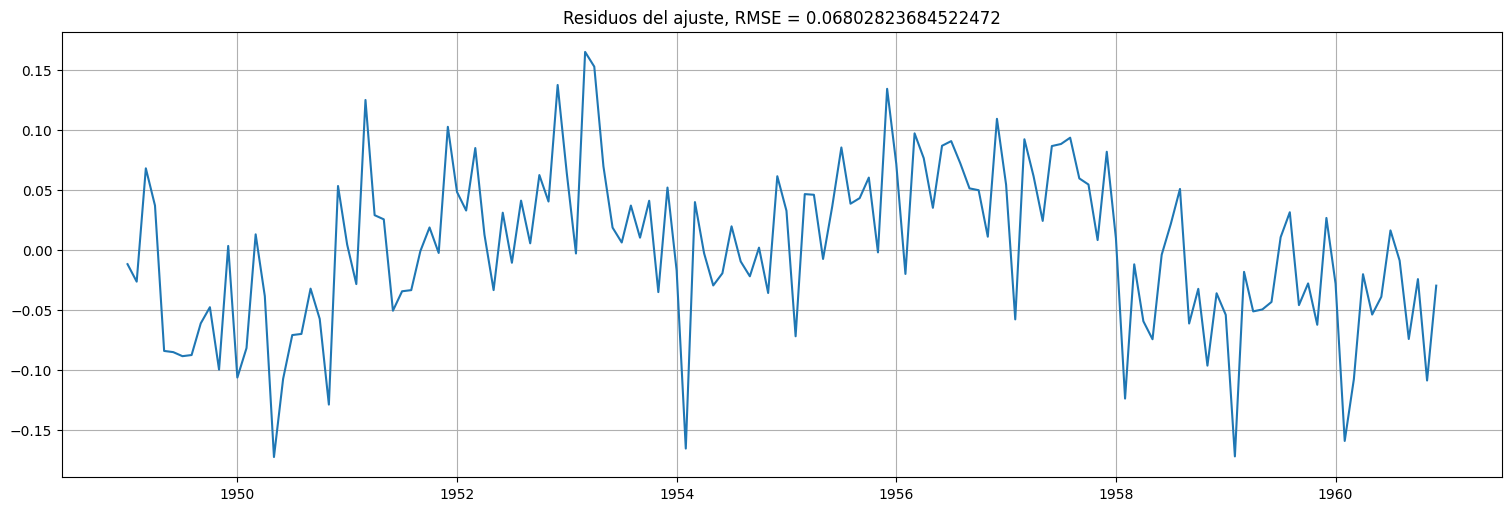

In [34]:
fit.resid.plot()
plt.title(f"Residuos del ajuste, RMSE = {np.sqrt(fit.mse_resid)}");

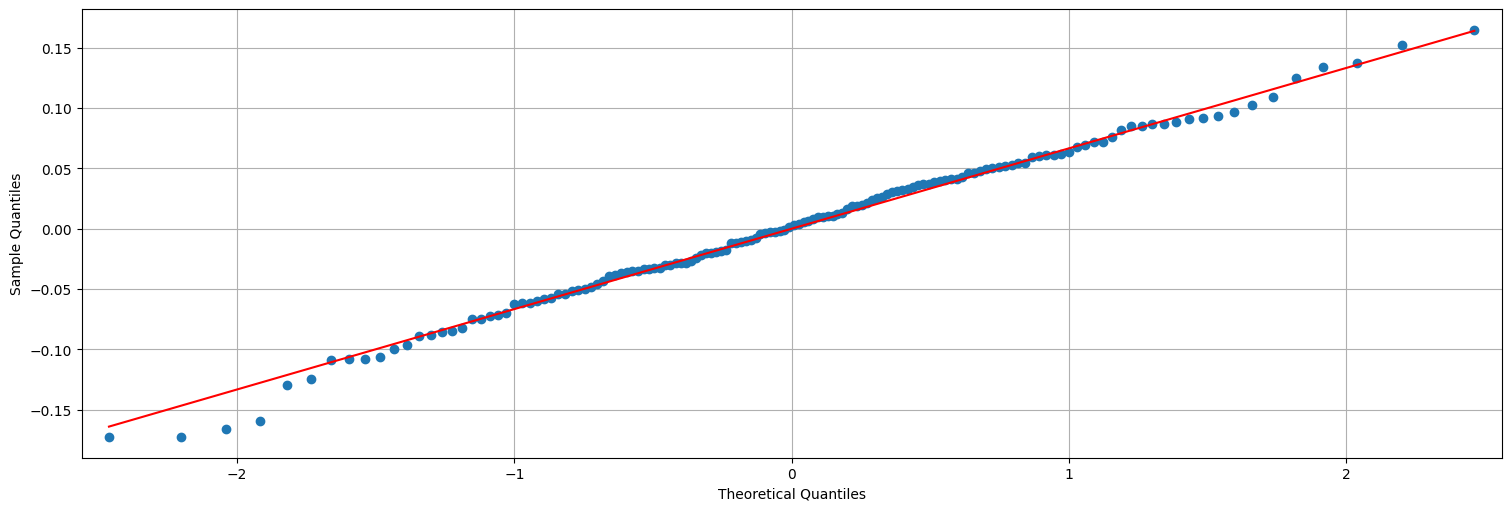

In [35]:
## QQ-plot es una verificación de gaussianidad.
sm.qqplot(fit.resid, line="s");

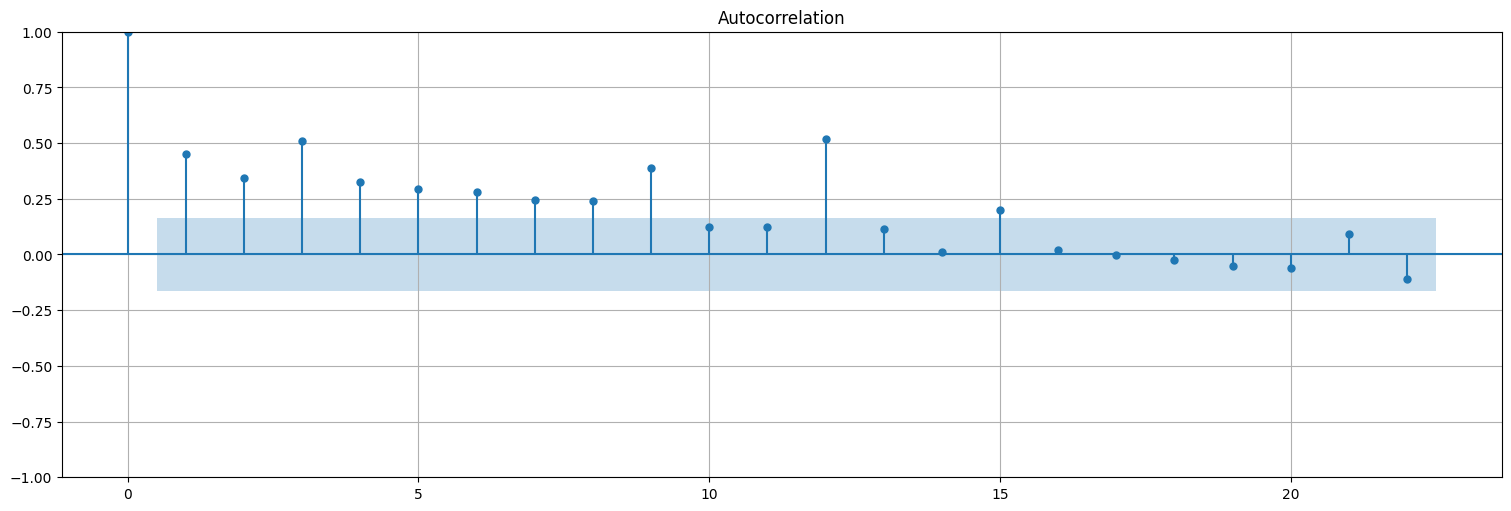

In [36]:
plot_acf(fit.resid.values, bartlett_confint=False);

### Volvemos ahora a la escala original

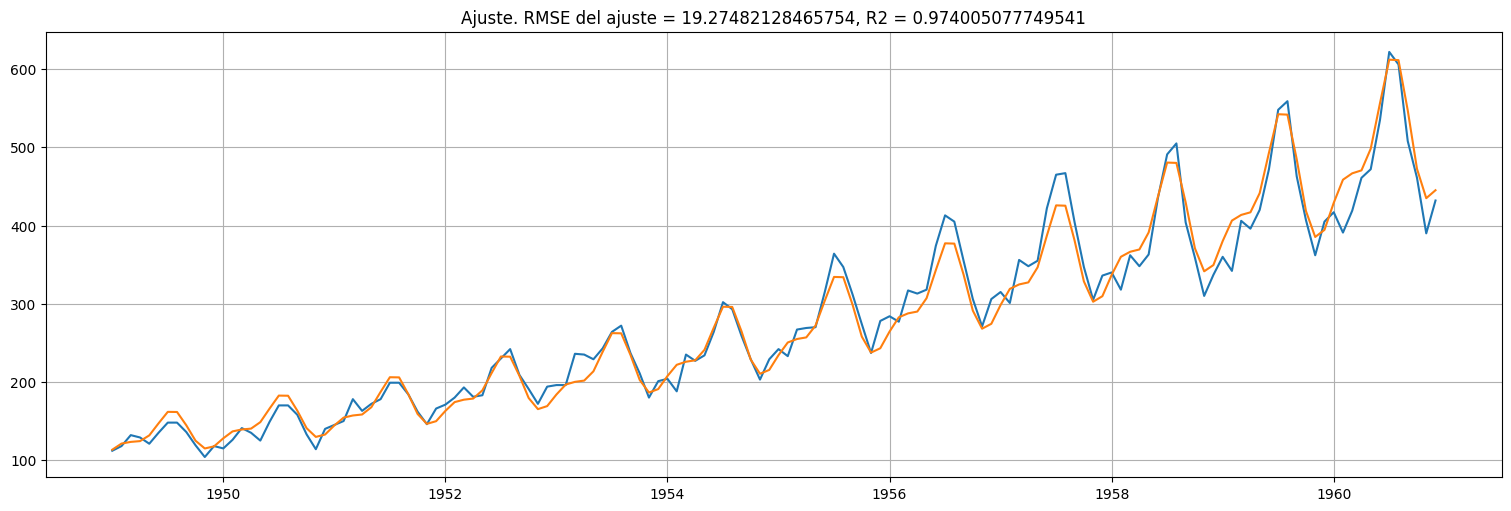

In [37]:
fitted_values = np.exp(fit.fittedvalues)
air.plot()
fitted_values.plot()
rmse = np.std(air-fitted_values)
R2 = (np.var(air)-np.var(air-fitted_values))/np.var(air)
plt.title(f"Ajuste. RMSE del ajuste = {rmse}, R2 = {R2}");

## Ejercicio

### Análisis frecuencial del fenómeno del niño (serie $soi$).

En este ejercicio, se busca explorar la naturaleza periódica de $S_t$, la serie SOI ya analizada.

1. Quitar la tendencia a las serie mediante una regresión lineal en la componente tiempo. ¿Hay una tendencia significativa en la temperatura de superficie?

2. Calcular el periodograma para la serie sin tendencia (residuos) de la parte anterior. Identificar las frecuencias principales (una obvia es la anual). ¿Cuál es el ciclo probable del fenómeno del Niño que refleja el pico más pequeño?
